# Consumer Spending Project

## Summary

This project will analyze time-series data of anonymized purchase data from consumer credit and debit cards in the United States across 3 datasets. The datasets are split by the national level, state level, and the city level. It will explore spending relations between different market category codes and consumer income in order to generate insights for data-driven action.

### Questions of Interest

National Level
- When did the United States return to pre-pandemic levels of spending?
- What are the spending trends between the four quartiles of median income across all market category codes?
- Do these trends persist in essential categories such as spending in grocery and food stores?
- Is there a correlation between time and spending in any category code?
  
  
State Level
- In which states do the lower quantiles spend more than the higher quanrtiles relatively? Which state has the biggest difference?
- In which states do the higher quantiles spend more than the lower quanriles relatively? Which state has the biggest difference?
- In which states do the higher and lower quartiles spend roughly the same relatively?
  
City Level
- Which cities experienced the steepest spending declines during the beginning of lockdown?
- How did spending differ between cities with large tourist economies and cities focusing on industry and government?

### Data Schema

There are 5 tables within this project; 3 of them are described above and the last 2 are geographic identifiers for states and cities.

For a data dictionary of the columns for each table, refer to [OIET Data Dictionary](https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_dictionary.md). The descriptions of interest are:
- GeoID File Descriptions : **State** and **City**
- Data File Descriptions : **Affinity**

---

## Importing Libraries & User Functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm

### Functions and Global Varaibles

In [2]:
# Shades of gray to use for plotting
grey10 = "#1a1a1a"
grey30 = "#4d4d4d"
grey40 = "#666666"
grey50 = "#7f7f7f"
grey60 = "#999999"
grey75 = "#bfbfbf"
grey91 = "#e8e8e8"
grey98 = "#fafafa"

In [3]:
def custom_timeseries_plot(plt_style='seaborn-v0_8-whitegrid', ylabel='y-axis', nrows=1, ncols=1, fig_size=(16, 9), title='title', spine_color='#7f7f7f', xlim_left=-10, xlim_right=10, ylim_bottom=-10, ylim_top=10):
    """
    Create an empty but customized timeseries plot using Matplotlib.pyplot and returns fig, ax for plotting purposes.

    Parameters
    ----------
    plt_style : str, default 'seaborn-v0_8-whitegrid'
        The Matplotlib style desired for the plot

    fig_size : tuple of length 2, default (16,9)
        Sets the size of the figure

    nrows : int, default 1
        Sets the number of rows of subplots

    ncows : int, default 1
        Sets the number of columns of subplots
    
    title : str, default 'title'
        Sets the title of the plot
        
    ylabel : str, default 'y-axis'
        Sets y-axis label

    spine_color : str, default='#7f7f7f'
        Sets the spine and tick colors

    xlim_left : int, default -10
        Sets lower bound of x-axis

    xlim_right : int, default 10
        Sets upper bound of x-axis

    ylim_bottom : int, default -10
        Sets lower bound of y-axis

    ylim_top : int, default 10
        Sets upper bound of y-axis

    fontsize : int, default 12
        Sets fontsize for reference line labels

    Returns
    ----------
    Figure, Axes
    """
    
    # Initialize layout
    plt.style.use(plt_style)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = fig_size)
    
    # Title Customization
    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    
    # Spine Customization
    ax.spines[:].set_color(spine_color)
    ax.spines[:].set_linewidth(3)
    
    # Axes Customization
    ax.tick_params(direction='out', length=8, width=3, color=spine_color, labelsize=11)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim(left=xlim_left, right=xlim_right)
    
    ax.set_ylabel(ylabel, fontsize=14, labelpad=5)
    ax.set_ylim(bottom=ylim_bottom, top=ylim_top)

    return fig, ax

In [4]:
def insert_covid_ref_lines(ax, zero_ref_line=False, natl_emerg=False, natl_recov=False, height=0, z=0, fontsize=12):
    """
    Plots the National Emergency and Recovery Dates as vertical dotted lines. Has option to thicken the x-axis.

    Parameters
    ----------
    ax : Axes
        Required in order to specify which axes to modify

    zero_ref_line : bool, default True
        If true, plot a thick line at y=0

    natl_emerg : bool, default False
        If true, plot a vertical dotted line at natl_emerg_date

    natl_recov : bool, default False
        If true, plot a vertical dotted line at recovery_date

    height : int, default 0
        Set height of the vertical reference line labels

    z : int, defalut 0
        Set z-order of the vertical reference line labels
    """
    
    # Add Important Reference Lines and labels
    if zero_ref_line:
        ax.axhline(y=0, color=grey50, lw=3, alpha=0.5)

    if natl_emerg:
        ax.axvline(x=natl_emerg_date, color=grey50, ls='dotted', zorder=z)
        ax.text(
            x=natl_emerg_date + pd.DateOffset(days=3),
            y=height, 
            s='National Emergency Declared', 
            fontsize=fontsize, 
            fontweight='bold', 
            color=grey40,
            ha='left'
        )

    if natl_recov:
        ax.axvline(x=recovery_date, color=grey50, ls='dotted', zorder=z)
        ax.text(
            x=recovery_date - pd.DateOffset(days=3),
            y=height, 
            s='National Recovery Date',
            fontsize=fontsize, 
            fontweight='bold', 
            color=grey40,
            ha='right'
        )

---

## Data Wrangling

In [5]:
natl_daily = pd.read_csv('data/Affinity - National - Daily.csv')
st_daily = pd.read_csv('data/Affinity - State - Daily.csv')
city_daily = pd.read_csv('data/Affinity - City - Daily.csv')

cities = pd.read_csv('data/GeoIDs - City.csv')
states = pd.read_csv('data/GeoIDs - State.csv')

### Data Cleaning

#### National Level

Let's explore the first dataset. We'll be looking to handle missing data, verify column dtypes, and reomve duplicate data.

In [6]:
natl_daily.head()

,year,month,day,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,...,spend_s_all_q1,spend_s_all_q2,spend_s_all_q3,spend_s_all_q4,spend_s_inperson,spend_s_retail_no_grocery,spend_s_retail_w_grocery,spend_19_retail_no_grocery,spend_19_retail_w_grocery,provisional
0,2018,12,31,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
1,2019,1,1,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
2,2019,1,2,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
3,2019,1,3,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
4,2019,1,4,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0


In [7]:
natl_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Columns: 142 entries, year to provisional
dtypes: int64(4), object(138)
memory usage: 1.5+ MB


It appears that the raw data stores empty values as `.`. Because of this, all the spending variables are of type `object`. We would like them to be of type `float32`.

In [8]:
# Replace `.` with NaN so we can easily convert to the right dtype afterwards
natl_daily = natl_daily.replace('.', np.nan)

# Convert all columns with "spend_" from dtype object to float32
for col in [col for col in natl_daily.columns if 'spend_' in col]:
    natl_daily[col] = natl_daily[col].astype('float32')

Let's also add a new column which takes the `year`, `month`, and `day` and combines them into a single date.

In [9]:
# Make a date Series using the year, month, and day columns
date_dict = dict(year=natl_daily['year'], month=natl_daily['month'], day=natl_daily['day'])
date_col = pd.Series(pd.to_datetime(date_dict), name='date')

# Concatenate the date Series onto the main DataFrame at the beginning
natl_daily = pd.concat([date_col, natl_daily], axis=1)

Now, we will find out how many NaNs we have.

In [10]:
# Get number of rows that have NaNs values
print('Number of rows with null values : ', natl_daily.isna().any(axis=1).sum())
print('Number of cols with null values : ', natl_daily.isna().any(axis=0).sum())

Number of rows with null values :  378
Number of cols with null values :  137


We have that 378/1358 rows and 137/143 columns have null values. Because there are a significant amount of nulls, we cannot afford to drop them. Instead, let's replace each null with its column's median.

In [11]:
# Replace all NaNs with its column's median
for col in natl_daily.columns:
    if natl_daily[col].isna().any():
        natl_daily[col] = natl_daily[col].fillna(np.nanmedian(natl_daily[col]))

In [12]:
# Check for any nulls
print(natl_daily.isna().any().sum())

0


Let's now check for any duplicated values in our DataFrame.

In [13]:
print('Duplicated values : ', natl_daily.duplicated().sum())

Duplicated values :  0


Ok, we have successfully cleaned this DataFrame.

In [14]:
natl_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Columns: 143 entries, date to provisional
dtypes: datetime64[ns](1), float32(137), int64(4), object(1)
memory usage: 791.1+ KB


In [15]:
natl_daily.sample(5)

,date,year,month,day,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,...,spend_s_all_q1,spend_s_all_q2,spend_s_all_q3,spend_s_all_q4,spend_s_inperson,spend_s_retail_no_grocery,spend_s_retail_w_grocery,spend_19_retail_no_grocery,spend_19_retail_w_grocery,provisional
715,2020-12-15,2020,12,15,d,-0.0377,-0.0765,-0.28500,-0.4620,-0.0131,...,0.151,0.122,0.103,0.0706,-0.30800,0.660,0.4860,0.718,0.5430,0
92,2019-04-02,2019,4,2,d,0.0756,0.0822,0.00318,-0.0333,0.1700,...,0.118,0.117,0.113,0.1130,-0.00618,0.135,0.0793,0.135,0.0793,0
853,2021-05-02,2021,5,2,d,0.0663,0.1400,-0.00198,-0.1750,0.1860,...,0.202,0.152,0.133,0.0830,0.00810,0.392,0.2490,0.440,0.2960,0
1313,2023-08-06,2023,8,6,w,0.2180,0.0515,0.09270,0.4260,0.2660,...,0.331,0.286,0.263,0.2100,0.28000,0.314,0.2370,0.360,0.2840,0
992,2021-09-18,2021,9,18,d,0.0848,0.1770,0.03890,0.0238,0.2220,...,0.165,0.125,0.103,0.0527,0.00877,0.292,0.1940,0.337,0.2390,0


#### State Level

Let's move onto the next dataset. Again, we'll be looking to handle missing data, verify column dtypes, and reomve duplicate data.

In [16]:
st_daily.head()

,year,month,day,statefips,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,...,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,spend_all_incmiddle,spend_all_q1,spend_all_q2,spend_all_q3,spend_all_q4,provisional
0,2018,12,31,1,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
1,2018,12,31,2,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
2,2018,12,31,4,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
3,2018,12,31,5,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
4,2018,12,31,6,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0


In [17]:
st_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50694 entries, 0 to 50693
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   year                     50694 non-null  int64 
 1   month                    50694 non-null  int64 
 2   day                      50694 non-null  int64 
 3   statefips                50694 non-null  int64 
 4   freq                     50694 non-null  object
 5   spend_all                50694 non-null  object
 6   spend_aap                50694 non-null  object
 7   spend_acf                50694 non-null  object
 8   spend_aer                50694 non-null  object
 9   spend_apg                50694 non-null  object
 10  spend_durables           50694 non-null  object
 11  spend_nondurables        50694 non-null  object
 12  spend_grf                50694 non-null  object
 13  spend_gen                50694 non-null  object
 14  spend_hic                50694 non-nul

It appears that the raw data stores empty values as `.`. Because of this, all the spending variables are of type `object`. We would like them to be of type `float32`.

In [18]:
# Replace `.` with NaN so we can easily convert to the right dtype afterwards
st_daily = st_daily.replace('.', np.nan)

# Convert all columns with "spend_" from dtype object to float32
for col in [col for col in st_daily.columns if 'spend_' in col]:
    st_daily[col] = st_daily[col].astype('float32')

Let's also add a new column which takes the `year`, `month`, and `day` and combines them into a single date.

In [19]:
# Make a date Series using the year, month, and day columns
date_dict = dict(year=st_daily['year'], month=st_daily['month'], day=st_daily['day'])
date_col = pd.Series(pd.to_datetime(date_dict), name='date')

# Concatenate the date Series onto the main DataFrame at the beginning
st_daily = pd.concat([date_col, st_daily], axis=1)

In addition, let's add the state names and abbreviations to our main DataFrame.

In [20]:
# Get stateabbrevs and names from states df with a left join
st_daily = pd.merge(st_daily, states[['statefips', 'stateabbrev', 'statename']], on='statefips', how='left')

# Move statename and abbrev next to statefips
stateabbrevs = st_daily.pop('stateabbrev')
statenames = st_daily.pop('statename')

st_daily.insert(loc=5, column='stateabbrev', value=stateabbrevs)
st_daily.insert(loc=6, column='statename', value=statenames)

Now, we will find out how many NaNs we have.

In [21]:
# Get number of rows that have null values
print('Number of rows with null values : ', st_daily.isna().any(axis=1).sum())
print('Number of cols with null values : ', st_daily.isna().any(axis=0).sum())

Number of rows with null values :  6549
Number of cols with null values :  23


Because of the significant amount of NaNs, we cannot afford to drop them. We will use each column's median instead.

In [22]:
# Replace all NaNs with its column's median
for col in st_daily.columns:
    if st_daily[col].isna().any():
        st_daily[col] = st_daily[col].fillna(np.nanmedian(st_daily[col]))

In [23]:
# Check for any nulls
print(st_daily.isna().any().sum())

0


In [24]:
# Check for duplicated values
print(st_daily.duplicated().sum())

0


In [25]:
st_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50694 entries, 0 to 50693
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     50694 non-null  datetime64[ns]
 1   year                     50694 non-null  int64         
 2   month                    50694 non-null  int64         
 3   day                      50694 non-null  int64         
 4   statefips                50694 non-null  int64         
 5   stateabbrev              50694 non-null  object        
 6   statename                50694 non-null  object        
 7   freq                     50694 non-null  object        
 8   spend_all                50694 non-null  float32       
 9   spend_aap                50694 non-null  float32       
 10  spend_acf                50694 non-null  float32       
 11  spend_aer                50694 non-null  float32       
 12  spend_apg                50694 n

In [26]:
st_daily.sample(5)

,date,year,month,day,statefips,stateabbrev,statename,freq,spend_all,spend_aap,...,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,spend_all_incmiddle,spend_all_q1,spend_all_q2,spend_all_q3,spend_all_q4,provisional
28771,2021-07-17,2021,7,17,10,DE,Delaware,d,0.0824,0.306,...,0.821,-0.138,0.211,0.2920,0.0828,0.2890,0.0771,0.0851,0.0617,0
22578,2021-03-17,2021,3,17,40,OK,Oklahoma,d,0.1530,0.285,...,0.761,-0.289,0.234,0.3760,0.1370,0.1900,0.2020,0.0610,0.1300,0
36519,2021-12-16,2021,12,16,5,AR,Arkansas,d,0.2270,0.216,...,0.462,1.690,0.223,0.2990,0.1390,0.2840,0.1620,0.0918,0.0501,0
6860,2020-05-13,2020,5,13,30,MT,Montana,d,-0.2430,-0.225,...,-0.126,-0.708,-0.109,-0.1260,-0.2290,-0.2800,-0.1910,-0.2690,-0.0959,0
4100,2020-03-20,2020,3,20,24,MD,Maryland,d,-0.1150,-0.499,...,0.084,-0.582,0.231,-0.0516,-0.1080,-0.0424,-0.0449,-0.1350,-0.1280,0


#### City Level

In [27]:
city_daily.head(5)

,year,month,day,cityid,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,...,spend_hic,spend_hcs,spend_inperson,spend_inpersonmisc,spend_remoteservices,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,provisional
0,2018,12,31,1,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
1,2018,12,31,2,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
2,2018,12,31,3,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
3,2018,12,31,4,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
4,2018,12,31,5,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0


In [28]:
city_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48706 entries, 0 to 48705
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   year                     48706 non-null  int64 
 1   month                    48706 non-null  int64 
 2   day                      48706 non-null  int64 
 3   cityid                   48706 non-null  int64 
 4   freq                     48706 non-null  object
 5   spend_all                48706 non-null  object
 6   spend_aap                48706 non-null  object
 7   spend_acf                48706 non-null  object
 8   spend_aer                48706 non-null  object
 9   spend_apg                48706 non-null  object
 10  spend_durables           48706 non-null  object
 11  spend_nondurables        48706 non-null  object
 12  spend_grf                48706 non-null  object
 13  spend_gen                48706 non-null  object
 14  spend_hic                48706 non-nul

We wil repeat the above process of removing `.` and then changing the relevant dtypes.

In [29]:
# Replace `.` with NaN so we can easily convert to the right dtype afterwards
city_daily = city_daily.replace('.', np.nan)

# Convert all columns with "spend_" from dtype object to float32
for col in [col for col in city_daily.columns if 'spend_' in col]:
    city_daily[col] = city_daily[col].astype('float32')

Let's also add a new column which takes the `year`, `month`, and `day` and combines them into a single date.

In [30]:
# Make a date Series using the year, month, and day columns
date_dict = dict(year=city_daily['year'], month=city_daily['month'], day=city_daily['day'])
date_col = pd.Series(pd.to_datetime(date_dict), name='date')

# Concatenate the date Series onto the main DataFrame at the beginning
city_daily = pd.concat([date_col, city_daily], axis=1)

Now, let's add the city names using a left join.

In [31]:
# Get only city names from cities df with a left join
city_daily = pd.merge(city_daily, cities[['cityid', 'cityname']], on='cityid', how='left')

# Move cityname next to cityid
col = city_daily.pop('cityname')
city_daily.insert(loc=5, column='cityname', value=col)

Now, we will find out how many NaNs we have.

In [32]:
# Get number of rows that have null values
print('Number of rows with null values : ', city_daily.isna().any(axis=1).sum())
print('Number of cols with null values : ', city_daily.isna().any(axis=0).sum())

Number of rows with null values :  2599
Number of cols with null values :  18


Because of the significant amount of NaNs, we cannot afford to drop them. We will use each column's median instead.

In [33]:
# Replace all NaNs with its column's median
for col in city_daily.columns:
    if city_daily[col].isna().any():
        city_daily[col] = city_daily[col].fillna(np.nanmedian(city_daily[col]))

In [34]:
# Check for any nulls
print(st_daily.isna().any().sum())

0


In [35]:
# Check for duplicated values
print(st_daily.duplicated().sum())

0


In [36]:
city_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48706 entries, 0 to 48705
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     48706 non-null  datetime64[ns]
 1   year                     48706 non-null  int64         
 2   month                    48706 non-null  int64         
 3   day                      48706 non-null  int64         
 4   cityid                   48706 non-null  int64         
 5   cityname                 48706 non-null  object        
 6   freq                     48706 non-null  object        
 7   spend_all                48706 non-null  float32       
 8   spend_aap                48706 non-null  float32       
 9   spend_acf                48706 non-null  float32       
 10  spend_aer                48706 non-null  float32       
 11  spend_apg                48706 non-null  float32       
 12  spend_durables           48706 n

In [37]:
city_daily.sample(5)

,date,year,month,day,cityid,cityname,freq,spend_all,spend_aap,spend_acf,...,spend_hic,spend_hcs,spend_inperson,spend_inpersonmisc,spend_remoteservices,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,provisional
16339,2020-11-28,2020,11,28,25,Boston,d,-0.086700,-0.2700,-0.3950,...,1.890,-0.11200,-0.418,-0.09690,0.08010,0.370,-0.6710,0.251,0.293,0
27819,2021-07-20,2021,7,20,41,Oakland,d,-0.006720,0.0917,-0.0576,...,0.482,0.03880,-0.101,-0.06360,0.00757,0.226,-0.2900,0.137,0.224,0
22132,2021-03-26,2021,3,26,38,Miami,d,0.000914,0.0761,-0.0363,...,0.278,-0.00357,-0.159,-0.04970,-0.07030,0.449,-0.4640,0.175,0.266,0
40493,2022-04-05,2022,4,5,22,El Paso,d,0.138000,0.2330,0.1870,...,0.169,0.38700,0.115,0.00487,-0.03340,0.489,-0.0941,0.364,0.433,0
19743,2021-02-05,2021,2,5,50,Salt Lake City,d,0.057100,-0.0425,-0.1010,...,0.645,0.17100,-0.154,0.13900,0.13100,0.337,-0.5800,0.235,0.294,0


---

---

## Exploratory Data Analysis

### National Level

##### **When did the United States return to pre-pandemic levels of spending?**

We know that consumer spending dropped sharply after the national emergency for Covid-19 was declared on March 13, 2020. When did it return to pre-pandemic levels?

It is important to note that all spending variables are measured relative to the period Jan. 6 to Feb. 2, 2020, seasonally adjusted, and calculated as a per day average or 7 day moving average depending on `freq`. When a spending variable has `freq` equal to `w`, it is a 7 day average and its `date` value is 7 days from the previous record. This period from Jan. 6 to Feb. 2 will sometimes be refered to as the baseline.

In [38]:
natl_emerg_date = pd.to_datetime('2020-03-13')

In [39]:
post_emerg = natl_daily['date'] > natl_emerg_date
spending_near_zero = np.isclose(a=natl_daily['spend_all'], b=0, atol=1e-2)
spending_positive = natl_daily['spend_all'] > 0

recovery_dates = natl_daily[post_emerg & spending_near_zero & spending_positive][['date', 'spend_all']]
recovery_date = recovery_dates['date'].max()
print('National Recovery Date : ', recovery_date)

National Recovery Date :  2021-02-19 00:00:00


##### **What are the spending trends between the four quartiles of median income across all market category codes?**

We see that as a nation, we first returned to pre-pandemic levels of spending around Jan. 6, 2021. Spending fluctuates and it happens again on Feb. 19, 2021. Afterwards, consumer spending continues to grow past pre-pandemic baseline levels.

Let us investigate the spending trends between high-income zipcodes and low-income zipcodes during the recovery period across all market category codes (MCCs). `Q1` is the quartile with the lowest median income zipcodes and `Q4` is the quartile with the highest median income zipcodes.

In [40]:
# Filter for a month before national emergency date until a month after recovery date and for quartile spending in all MCCs
month_offset = 1
start_date = (natl_emerg_date - pd.DateOffset(months=month_offset))
end_date = (recovery_date + pd.DateOffset(months=month_offset))
quartiles = ['spend_all_q1', 'spend_all_q2', 'spend_all_q3', 'spend_all_q4']

spending_quartiles = natl_daily[(natl_daily['date'] >= start_date) & (natl_daily['date'] <= end_date)][['date'] + quartiles]
spending_quartiles = spending_quartiles.set_index('date')

In [41]:
# Find the lowest and highest spending average across the entire recovery precovery_period to the nearest tenth
min_spending = np.round(spending_quartiles.min().min(), decimals=1)
max_spending = np.round(spending_quartiles.max().max(), decimals=1)

print(min_spending, max_spending)

-0.4 0.2


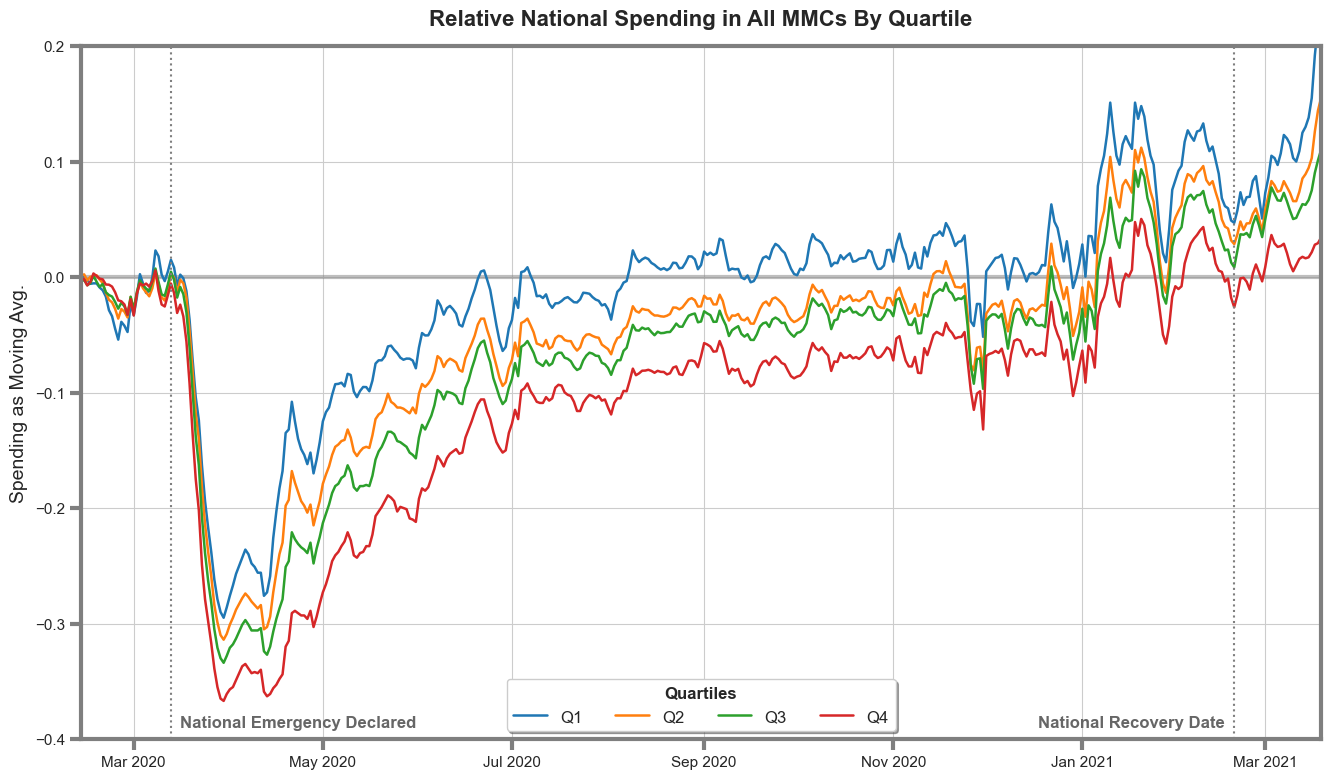

In [42]:
# Create plot
fig, ax = custom_timeseries_plot(
    title='Relative National Spending in All MMCs By Quartile',
    ylabel='Spending as Moving Avg.',
    xlim_left=start_date,
    xlim_right=end_date,
    ylim_bottom=min_spending,
    ylim_top=max_spending
)

# Include important reference lines
insert_covid_ref_lines(ax, zero_ref_line=True, natl_emerg=True, natl_recov=True, height=-0.39, z=3)

# Plot quartiles
for index, quartile in enumerate(spending_quartiles.columns):
    ax.plot(quartile, data=spending_quartiles, lw=1.8, label='Q' + str(index + 1))

# Legend Customization
ax.legend(
    loc='lower center',
    fontsize=12,
    ncols=4,
    title='Quartiles',
    title_fontproperties=fm.FontProperties(weight='bold', size=12),
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.show()

Recall that `Q1` is the quartile with the lowest median income zipcodes and `Q4` is the quartile with the highest median income zipcodes.

We can see that during the start of Covid-19, the lower quartiles had a higher relative spending than the higher quartiles. This does not mean they spend more money, but rather it suggests that the lower quartiles spend a larger portion of their wealth on average. Assuming that consumers only spent money on essentials, the higher relative spending of the lower quartile suggests that they needed to spend a larger portion of their money on essentials. 

##### **Do these trends persist in essential categories such as spending in grocery and food stores?**

In [43]:
# Get spending in grocery and food stores (GRF) MCCs by consumers living in zipcodes with median income in the quartile #
grocery_quartile = ['spend_grf_q1', 'spend_grf_q2', 'spend_grf_q3', 'spend_grf_q4']
spend_grocery_quartiles = natl_daily[(natl_daily['date'] >= start_date) & (natl_daily['date'] <= end_date)][['date'] + grocery_quartile]
spend_grocery_quartiles = spend_grocery_quartiles.set_index('date')

In [44]:
# Find the lowest and highest grocery and food store spending average across the entire recovery precovery_period to the nearest tenth
min_grocery_spending = np.round(spend_grocery_quartiles.min().min(), decimals=1)
max_grocery_spending = np.round(spend_grocery_quartiles.max().max(), decimals=1)

print(min_grocery_spending, max_grocery_spending)

-0.1 0.8


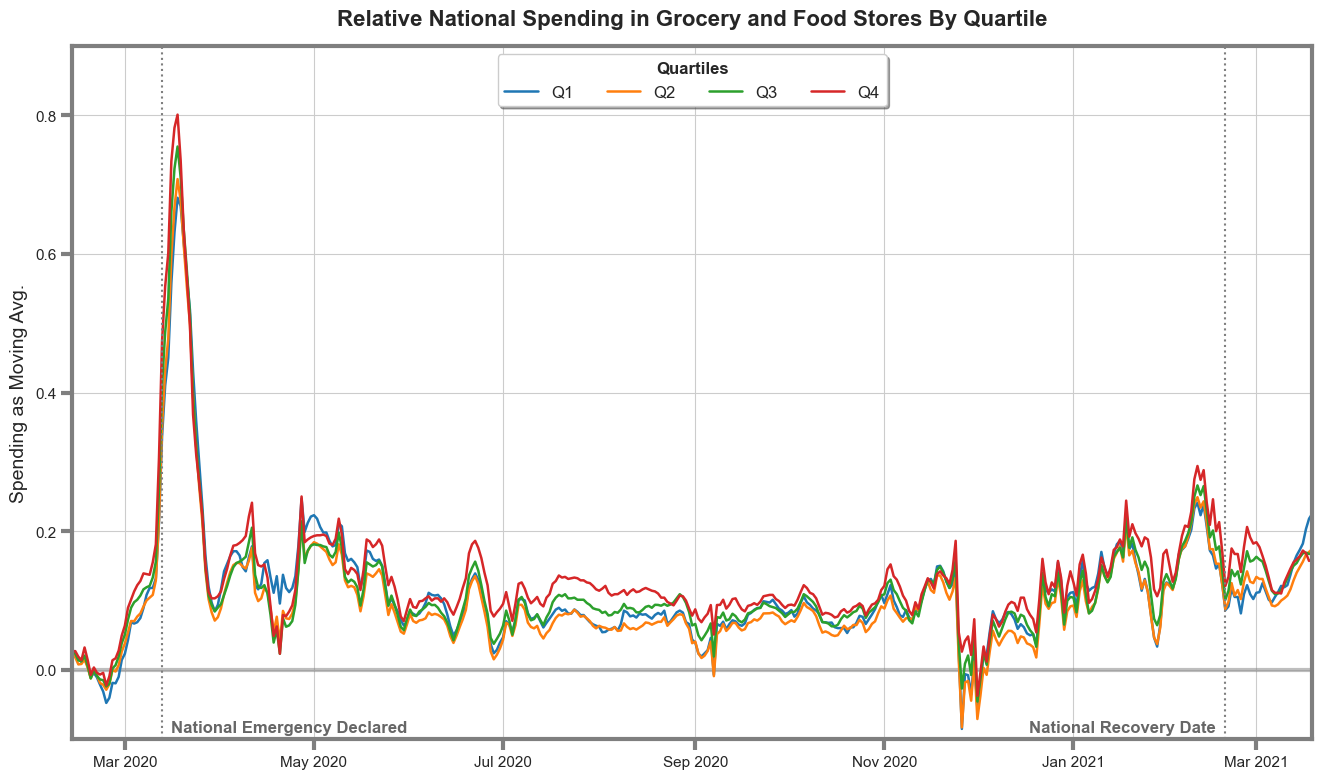

In [45]:
# Create plot
fig, ax = custom_timeseries_plot(
    title='Relative National Spending in Grocery and Food Stores By Quartile',
    ylabel='Spending as Moving Avg.',
    xlim_left=start_date,
    xlim_right=end_date,
    ylim_bottom=min_grocery_spending,
    ylim_top=max_grocery_spending + 0.1
)

# Include important reference lines
insert_covid_ref_lines(ax, zero_ref_line=True, natl_emerg=True, natl_recov=True, height=-0.09, z=3)

# Plot quartiles
for index, quartile in enumerate(spend_grocery_quartiles.columns):
    ax.plot(quartile, data=spend_grocery_quartiles, lw=1.8, label='Q' + str(index + 1))

# Legend Customization
ax.legend(
    loc='upper center',
    fontsize=12,
    ncols=4,
    title='Quartiles',
    title_fontproperties=fm.FontProperties(weight='bold', size=12),
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.show()

Throughout the recovery period, we see that all four quartiles had similar relative spending trends in grocery and food stores. Despite that, it's clear that Q4 was on average spending more of their money than the other quartiles. With the preceding figure in mind, this supports that the lower quartiles had to spend more of their wealth and money on essentials during the pandemic.

##### **Is there a correlation between time and spending in a certain category code?**

In [46]:
# Get all columns with general spending columns, that is, no quantile specific coulumns, with seasonal adjustments, and relative to the given baseline
include = 'spend_'
exclude = ['_q1', '_q2', '_q3', '_q4', '_19', '_s_']

corr_cols = [
    col for col in natl_daily.columns 
    if include in col and not any(e in col for e in exclude)
]
print(corr_cols)

['spend_all', 'spend_aap', 'spend_acf', 'spend_aer', 'spend_apg', 'spend_durables', 'spend_nondurables', 'spend_grf', 'spend_gen', 'spend_hic', 'spend_hcs', 'spend_inperson', 'spend_inpersonmisc', 'spend_remoteservices', 'spend_sgh', 'spend_tws', 'spend_retail_w_grocery', 'spend_retail_no_grocery', 'spend_all_incmiddle']


In [47]:
# Get correlation matrix
corr_df = natl_daily[['date'] + corr_cols]
corr = corr_df.corr()

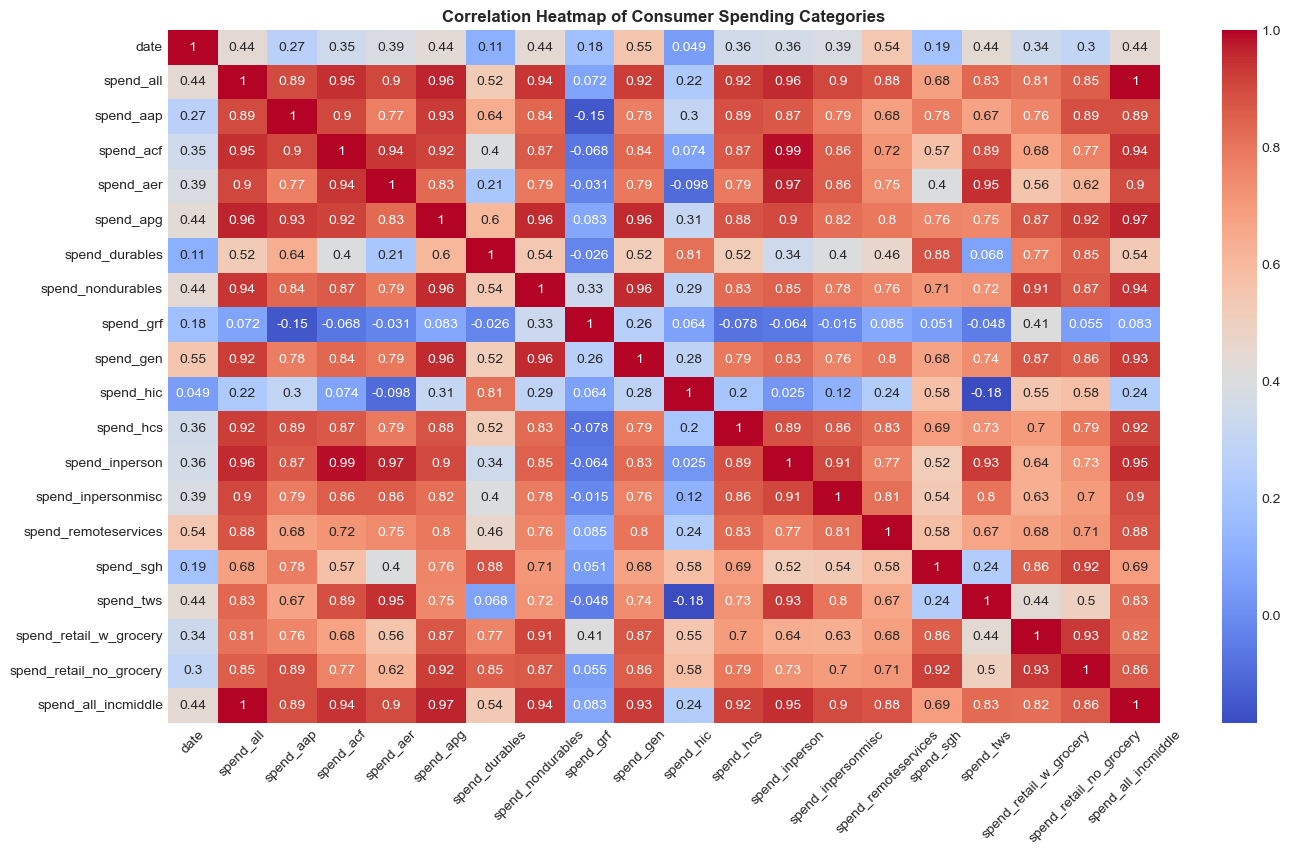

In [48]:
# Plot correlation matrix
plt.figure(figsize=(16,9))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.title('Correlation Heatmap of Consumer Spending Categories', fontweight='bold')
plt.show()

According to our heatmap, it unfortunately appears that the date is not very well correlated to spending in any category. However, most of the categories appear to be correlated to each other. This is because many of the MCCs have overlap. For instance, `spend_inperson` (spending in in-person services) and `spend_acf` (spending in accomodation and food services) have a correlation coefficient of 0.99 because most accomodation and food services are done in-person.

We can also see that `spend_grf` (spending in grocery and food store) and `spend_hic` (spending in home improvement centers) are not very related to any of the other MCCs.

### State Level


##### **In what states do the lower quantiles spend more than the higher quanitiles on average? Which state has the biggest difference?**
##### **In what sates do the higher quantiles spend more than the lower quantiles on average? Which state has the biggest difference?**

Let's continue exploring how the spending trends between quartiles. This time, we will explore the difference between the highest and lowest quartile spending per state.

In [49]:
st_min_date = st_daily['date'].min()
st_max_date = st_daily['date'].max()


quartile_by_st = st_daily[(st_daily['date'] >= st_min_date) & (st_daily['date'] <= st_max_date)][['date', 'statename'] + quartiles]
quartile_by_st['q4_q1_diff'] = quartile_by_st['spend_all_q4'] - quartile_by_st['spend_all_q1']
quartile_by_st = quartile_by_st.set_index('date')

quantile_by_state_sorted =  pd.DataFrame(quartile_by_st.groupby('statename')['q4_q1_diff'].mean().sort_values(ascending=False))
quantile_by_state_sorted

,q4_q1_diff
statename,
South Dakota,0.129840
Vermont,0.067358
Kansas,0.051902
Hawaii,0.042933
Kentucky,0.037002
Washington,0.019803
Nebraska,0.012476
New Hampshire,0.002706
Nevada,0.000307


Recall that `Q1` is the quartile with the lowest median income zipcodes and `Q4` is the quartile with the highest median income zipcodes.

Looking at this table, we see that positive values mean that the highest quartile spends more than the lowest, negative values mean that the lowest quartile spends more than the highest, and values close to 0 mean that the lowest and highest quartiles spend roughly the same on average and relative to its quartile.capitalize

South Dakota has the highest difference. Maryland has the lowest difference. Nevada and Arizona have the values closest to 0.

### City Level

##### **Which cities experienced the steepest spending declines during the beginning of lockdown?**

In [50]:
# Filter for dates slightly predating pandemic to a few months after
lockdown = city_daily.loc[(city_daily['date'] >= '2020-02-01') & (city_daily['date'] <= '2020-06-01')]

# Get the 5 cities with the lowest dips in all spending
bottom5 = lockdown.groupby('cityname')['spend_all'].agg('min').sort_values().head(5)
bottom5_citynames = list(bottom5.index)

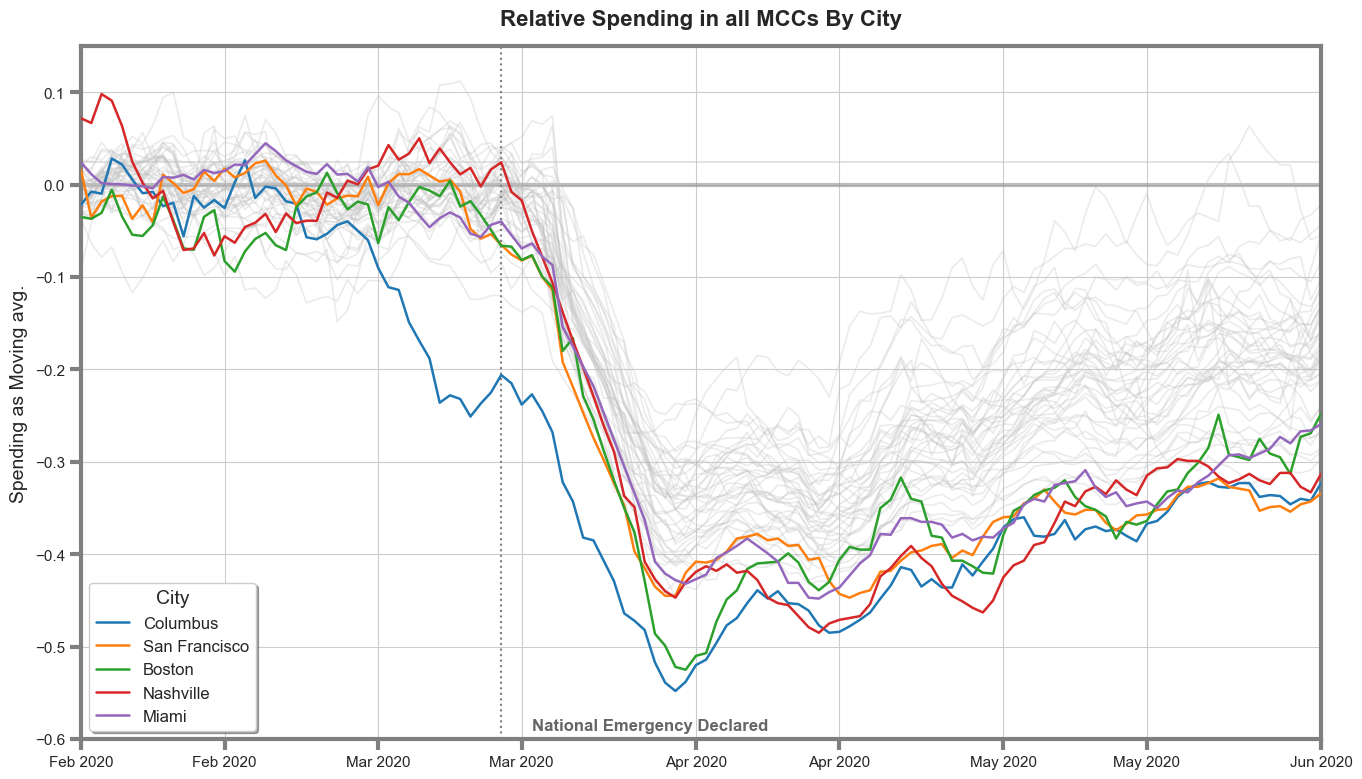

In [51]:
# Create plot
fig, ax = custom_timeseries_plot(
    title='Relative Spending in all MCCs By City',
    ylabel='Spending as Moving avg.',
    xlim_left=pd.to_datetime('2020-02-01'),
    xlim_right=pd.to_datetime('2020-06-01'),
    ylim_bottom=-0.6,
    ylim_top=0.15
)

insert_covid_ref_lines(ax, natl_emerg=True, zero_ref_line=True, height=-0.59, z=3)


# Plot spending vs date for all cities
for city in lockdown['cityname'].unique():
    data = lockdown[lockdown['cityname'] == city]
    if city in bottom5_citynames:
        # Plot and label the 5 cities with lowest dips in spending
        ax.plot('date', 'spend_all', data=data, lw=1.8, label=city, zorder=3)
    else:
        # Plot all other cities faintly and exclude them from the legend
        ax.plot('date', 'spend_all', data=data, lw=1.2, color=grey75, alpha = 0.30, label='_nolegend_')

# Legend
ax.legend(loc='lower left', fontsize=12, title_fontsize=14, title='City', frameon=True, fancybox=True, shadow=True)
plt.show()

Spending is measured relative to January 6 to February 2, 2020, seasonally adjusted, and calculated as a seven day moving average. That is, the period about four weeks before COVID disuptions began is used as the baseline for spending. The spending values are expressed relative to this baseline denoted at `y=0`.

We can see that the five cities with the steepest spending declines were Columbus, San Francisco, Boston, Nashville, and Miami. Out of the five, Columbus was first to decrease spending in all market category codes (MCC). It is not exactly obvious what these cities have in common.

However before that, let's look at the spending trends of a tourist city, such as Las Vegas, and an industrical city, like Los Angeles, across a few MCCs to see how they differ.

##### **How did spending differ between cities with large tourist economies and cities focusing on industry and government?**

In [52]:
la_vs_lv_cols = ['date', 'cityname', 'spend_grf', 'spend_sgh', 'spend_aer', 'spend_hic', 'spend_hcs', 'spend_acf']
la = lockdown.loc[city_daily['cityname'] == 'Los Angeles'][la_vs_lv_cols]
lv = lockdown.loc[city_daily['cityname'] == 'Las Vegas'][la_vs_lv_cols]

subplot_titles = [
    'Spending in Grocery and Food Store (GRF)', 
    'Spending in Sporting Goods and Hobby (SGH)',
    'Spending in Arts, Entertainment, and Recreation (AER)',
    'Spending in Home Improvement Centers (HIC)',
    'Spending in Health Care and Social Assistance (HCS)',
    'Spending in Accomodation and Food Service (ACF)'
]

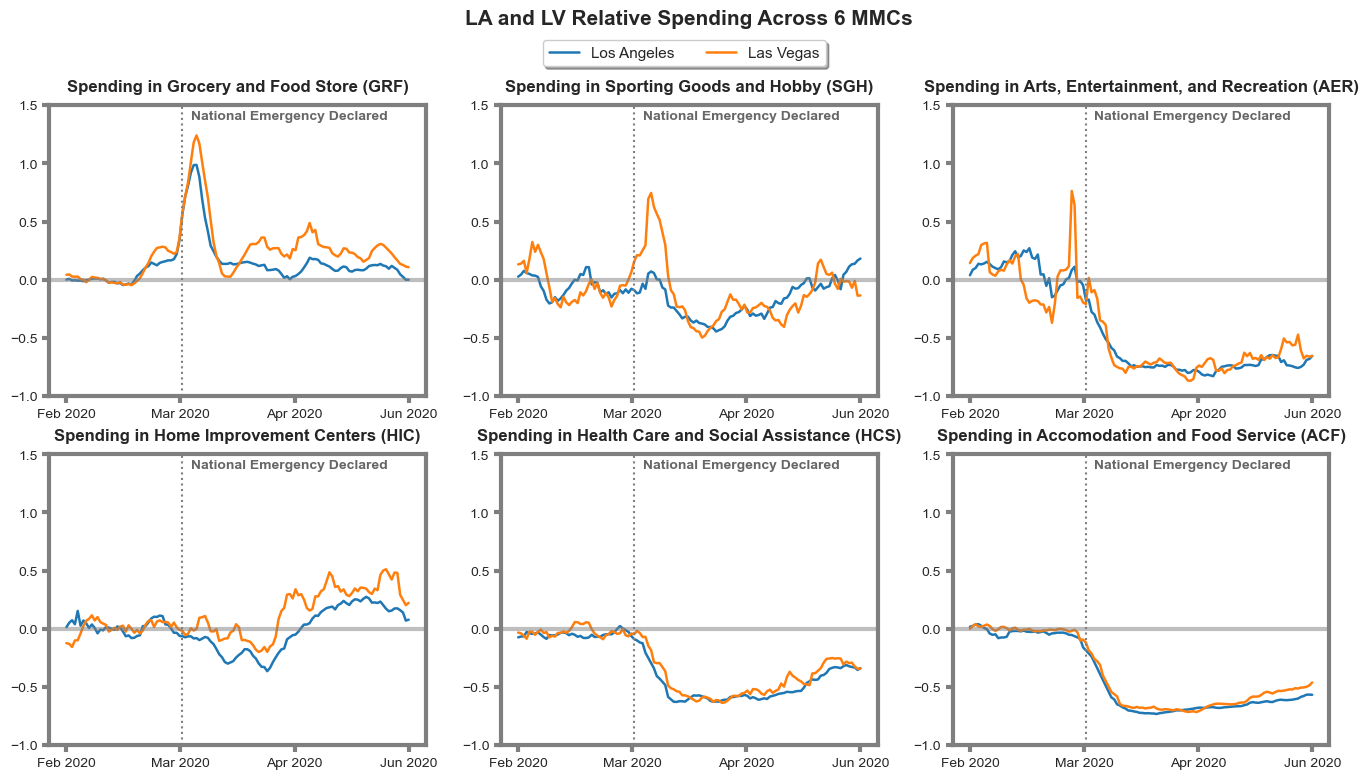

In [54]:
# Initialize layout
plt.style.use('seaborn-v0_8-white')
fig, axes = plt.subplots(2, 3, figsize=(16,8))

plt.subplots_adjust(
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.2,
    hspace=0.2
)

# Plot and customize each subplot
for i, ax in enumerate(axes.flat):
    # Plot values across axes
    ax.plot('date', la_vs_lv_cols[i+2], data=la, lw=1.8, label='Los Angeles')
    ax.plot('date', la_vs_lv_cols[i+2], data=lv, lw=1.8, label='Las Vegas')

    # Subplot titles
    ax.set_title(subplot_titles[i], fontsize=12, fontweight='bold', pad=10)

    # Border
    ax.spines[:].set_color(grey50)
    ax.spines[:].set_linewidth(3)
    
    # Axes 
    ax.tick_params(direction='out', length=5, width=3, color=grey50)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xticks(pd.date_range(start='2020-02-01', end='2020-06-01', periods=4))
    ax.set_yticks(np.arange(-1, 2, 0.5))

    insert_covid_ref_lines(ax, zero_ref_line=True, natl_emerg=True, height=1.38, z=3, fontsize=10)
    

# Legend
axes[0,0].legend(
    loc='upper left',
    ncols=2,
    fontsize=11,
    frameon=True, 
    fancybox=True,
    shadow=True, 
    bbox_to_anchor=(1.29, 1.25)
)

# Figure-level title
fig.suptitle('LA and LV Relative Spending Across 6 MMCs', fontsize=15, fontweight='bold', y=1.02)

plt.show()

Although Los Angeles and Las Vegas are quite different from one another, the relative consumer spending per MMC for each city follows the same long term trend. In SGH and AER, we do see two spikes in spending for Las Vegas, suggesting that residents in Las Vegas highly value entertainment and recreation. However, SGH seems to return to normal spending by June 2020 while AER remains well below baseline spending by June 2020. 

In GRF, we see that both cities spike in spending right after WHO officially announces the pandemic which can be explained by last minute panic buying. GRF also remains above baseline spending for the months afterwards.

For both Los Angeles and Las Vegas, spending in HIC increases after the pandemic is declared, suggesting that it was a common idea for people to upgrade their homes during lockdown.

HCS and ACF are two MMCs that follow a predicable trend: baseline spendinging until pandemic announcement, followed by a decline in spending, and then a shallow upwards trend in spending.

---

## Conclusion

National Level
- The United States returned to pre-pandemic levels of spending on February 19, 2021. Afterwards, average spending continues to increase.
- The lower quantiles relatively spend more than the higher quartiles. This does not necessarily mean the lower quanrtiles spend more than the higher quartiles, just that they spend a larger portion of their total money.
- These spending trends between the quartiles do not persist in some of the essential market category codes. We see that higher quartiles relative spend the most in grocery and food stores.
- There is little support that time and spending in any category code are correlated. However, most categories are correlated with an exception of grocery/food stores and home improvement.

State Level
- In Maryland, the lowest quartile relatively spends more of their total money than the highest quartile.
- In South Dakota, the highest quartile relatively spends more of their total money than the lowest quartile.
- In Nevada and Arizona, the highest and lowest quartiles relatively spend the same amount of their total money.

City Level
- Columbus, San Francisco, Boston, Nashville, and Miami suffered the steepest spending declines during the beginning of lockdown.
- Tourist cities such as Las Vegas value sports goods, hobbys, arts, entertainment, and recreation more than industrial cities such as Los Angeles.